In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [71]:
ds = xr.open_zarr('/burg/abernathey/users/hillary/lcs/spin_up/spin_up.zarr', decode_times=True)
ds

<xarray.Dataset>
Dimensions:     (time: 1080, l: 512, k: 257, lev: 2, lev_mid: 1, y: 512, x: 512)
Coordinates:
  * k           (k) float64 0.0 5.236e-06 1.047e-05 ... 0.00133 0.001335 0.00134
  * l           (l) float64 0.0 5.236e-06 1.047e-05 ... -1.047e-05 -5.236e-06
  * lev         (lev) int64 1 2
  * lev_mid     (lev_mid) float64 1.5
  * time        (time) timedelta64[ns] 5 days 10 days ... 5395 days 5400 days
  * x           (x) float64 1.172e+03 3.516e+03 ... 1.196e+06 1.199e+06
  * y           (y) float64 1.172e+03 3.516e+03 ... 1.196e+06 1.199e+06
Data variables: (12/21)
    APEflux     (time, l, k) float64 dask.array<chunksize=(1, 512, 257), meta=np.ndarray>
    APEgen      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    APEgenspec  (time, l, k) float64 dask.array<chunksize=(1, 512, 257), meta=np.ndarray>
    EKE         (time, lev) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    EKEdiss     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Ensspec     (time, lev, l, k) float64 dask.array<chunksize=(1, 2, 512, 257), meta=np.ndarray>
    ...          ...
    u           (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    ufull       (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    uh          (time, lev, l, k) complex128 dask.array<chunksize=(1, 2, 512, 257), meta=np.ndarray>
    v           (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    vfull       (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    vh          (time, lev, l, k) complex128 dask.array<chunksize=(1, 2, 512, 257), meta=np.ndarray>
Attributes: (12/23)
    pyqg:L:          1200000
    pyqg:M:          262144
    pyqg:W:          1200000
    pyqg:beta:       1.3e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  86400
    pyqg:tc:         777600
    pyqg:tmax:       466560000
    pyqg:twrite:     50000
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

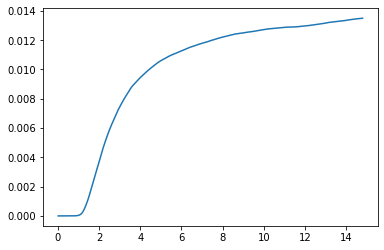

In [89]:
plt.plot(ds.time.values.astype('timedelta64[D]').astype('int')/365, ds.EKE[:,0])

In [85]:
ds.time.values.astype('timedelta64[D]').astype('int')

array([   5,   10,   15, ..., 5390, 5395, 5400])

In [1]:
import os
import numpy as np
import xarray as xr
import pyqg
from numpy.random import Generator, MT19937
import yaml


# model configuration
config_file = '/burg/home/hs3277/lcs-ml/config.yml'
with open(config_file) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
    
# Initialize QG Model
m = pyqg.QGModel(nx=config['nx'], L=config['L'], dt=config['dt'], tmax=config['tmax'], twrite=config['twrite'],
                 tavestart=config['tavestart'], ntd=config['ntd'], beta=config['beta'], rd=config['Ld'], delta=config['delta'],
                 H1=config['H1'], U1=config['U1'], U2=config['U2'], rek=config['rek']) 

# Set upper and lower layer PV anomalies (in spatial coordinates)
rg = Generator(MT19937(int(1)))
qi = config['sig']*rg.random((m.q.shape))
m.set_q(qi) 

INFO:  Logger initialized
INFO:  Logger initialized


In [2]:
# Run with snapshots and save model at each interval as netcdf
for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=config['day']*7):
    model = m.to_dataset()
    fn = '/burg/abernathey/users/hillary/pyqg_spin_up/'+ str('%d'%model.time.values[0]) +'.nc'
    model.to_netcdf(fn, engine='h5netcdf', invalid_netcdf=True, mode='a')

INFO: Step: 50000, Time: 3.00e+07, KE: 6.15e-05, CFL: 0.023
INFO: Step: 50000, Time: 3.00e+07, KE: 6.15e-05, CFL: 0.023
INFO: Step: 100000, Time: 6.00e+07, KE: 3.03e-03, CFL: 0.121
INFO: Step: 100000, Time: 6.00e+07, KE: 3.03e-03, CFL: 0.121
INFO: Step: 150000, Time: 9.00e+07, KE: 4.05e-03, CFL: 0.165
INFO: Step: 150000, Time: 9.00e+07, KE: 4.05e-03, CFL: 0.165
INFO: Step: 200000, Time: 1.20e+08, KE: 4.11e-03, CFL: 0.147
INFO: Step: 200000, Time: 1.20e+08, KE: 4.11e-03, CFL: 0.147
INFO: Step: 250000, Time: 1.50e+08, KE: 3.71e-03, CFL: 0.163
INFO: Step: 250000, Time: 1.50e+08, KE: 3.71e-03, CFL: 0.163
INFO: Step: 300000, Time: 1.80e+08, KE: 4.23e-03, CFL: 0.149
INFO: Step: 300000, Time: 1.80e+08, KE: 4.23e-03, CFL: 0.149
INFO: Step: 350000, Time: 2.10e+08, KE: 4.15e-03, CFL: 0.156
INFO: Step: 350000, Time: 2.10e+08, KE: 4.15e-03, CFL: 0.156
INFO: Step: 400000, Time: 2.40e+08, KE: 3.72e-03, CFL: 0.121
INFO: Step: 400000, Time: 2.40e+08, KE: 3.72e-03, CFL: 0.121
INFO: Step: 450000, Time: 